In [2]:
from data.byol_transform import *
import numpy as np
anno = '/home/jacklishufan/ByteTrack/datasets/coco/annotations/instances_train2017.json'
image_dir="/home/jacklishufan/detconb/imagenet"
root = '/home/jacklishufan/ByteTrack/datasets/coco/train2017'
stage = 'train'
mask_type = 'fh'
transform1 = get_transform(stage)
transform2 = get_transform(stage, gb_prob=0.1, solarize_prob=0.2)
transform3 = get_transform('raw')
transform = MultiViewDataInjector([transform1, transform2,transform3],False)
image_dir_t = os.path.join(image_dir,'images', f"{'train' if stage in ('train', 'ft') else 'val'}")
mask_file = os.path.join(image_dir,'masks',stage+'_tf_img_to_'+mask_type+'.pkl')
mask_file_path = os.path.join(image_dir,'masks','train_tf')
dataset = SSLMaskDataset(image_dir_t,mask_file,transform=transform,mask_file_path=mask_file_path)

#print(img,np.unique(anno))

total files: 12811


In [7]:
from model import BYOLModel
import yaml
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torch import nn

In [8]:
image,mask,transform = dataset[0]
view1,view2,view_raw = image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])
<class 'torch.Tensor'>


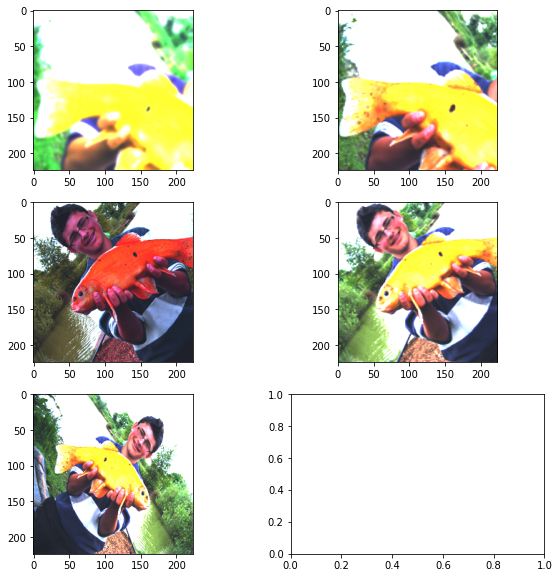

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [33]:
fig,ax = plt.subplots(3,2,figsize=(10,10))
view1,view2,view_raw = image
ax[0][0].imshow(np.exp(view1.permute(1,2,0)))
plt.figure()
ax[1][0].imshow(np.exp(view2.permute(1,2,0)))
plt.figure()
ax[2][0].imshow(np.exp(view_raw.permute(1,2,0)))
t = transform.unsqueeze(0)
idx = torch.LongTensor([1,0,3,2])
rois = [t[j,:2,:4].index_select(-1, idx)*224 for j in range(t.shape[0])]
aligned = ops.roi_align(view_raw.unsqueeze(0),rois,224)
plt.figure()
im = np.exp(aligned[0].permute(1,2,0))
if t[0][0][-1]==1:
    im = im.flip(1)
ax[0][1].imshow(im)
plt.figure()
im = np.exp(aligned[1].permute(1,2,0))
if t[0][1][-1]==1:
    print(im.shape)
    print(type(im))
    im = im.flip(1)
ax[1][1].imshow(im)

In [10]:
with open('/home/jacklishufan/detconb/config/train_imagenet_300_detcol.yaml') as f:
    config = yaml.safe_load(f)

In [23]:
torch.cuda.set_device(8)
device='cuda:8'

In [12]:
model = BYOLModel(config)

In [16]:
state = torch.load('/home/jacklishufan/detconb/ckpt/detconb/04_23_21-13/04_23_21-13_resnet50_50.pth.tar')

In [21]:
new_model = {}
for k,v in state['model'].items():
    if 'module' not in k:
        continue
    new_model[k.replace('module.','')] = v

In [22]:
model.load_state_dict(new_model)

<All keys matched successfully>

In [24]:
def get_masks(img,src='online'):
    with torch.no_grad():
        if src == 'online':
            x = model.online_network.encoder(img.to(device))
        else:
            x = model.target_network.encoder(img.to(device))
        masks = model.masknet(x)
    return masks.cpu()
def get_masks_global(img,src='target'):
    with torch.no_grad():
        if src == 'online':
            x = model.online_network.encoder(img.to(device))
        else:
            x = model.target_network.encoder(img.to(device))
        masks = model.masknet(x)
    return masks.cpu()

In [35]:
model = model.cuda()


In [37]:
model.eval()

BYOLModel(
  (online_network): EncoderwithProjection(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(i

In [51]:
masks = get_masks_global(view_raw.unsqueeze(0))
masks = torch.softmax(masks,dim=1)

In [52]:
masks_label = torch.argmax(masks,dim=1)

In [53]:
masks_label

tensor([[[8, 8, 8, 8, 8, 8, 8],
         [8, 8, 8, 8, 8, 8, 8],
         [8, 8, 8, 8, 4, 4, 8],
         [8, 8, 8, 8, 8, 8, 8],
         [8, 8, 8, 8, 8, 8, 8],
         [8, 8, 8, 8, 8, 8, 8],
         [8, 8, 8, 8, 8, 8, 8]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


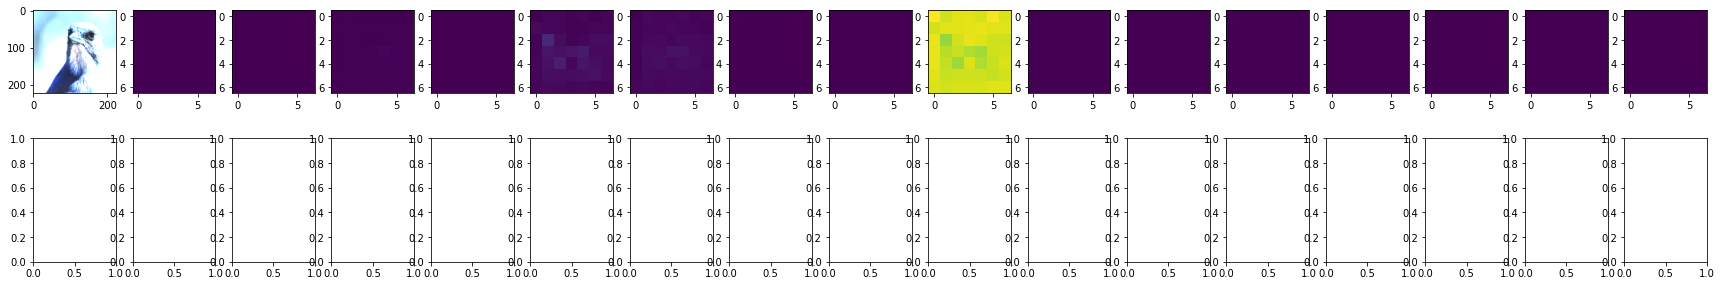

In [63]:
image,mask,transform = dataset[225]
masks = get_masks_global(view_raw.unsqueeze(0))
masks = torch.softmax(masks,dim=1)
view1,view2,view_raw = image
fig, axs = plt.subplots(2, 17,figsize=(30,5))
axs[0][0].imshow(np.exp(view_raw.permute(1,2,0)))
# axs[1][0].imshow(np.exp(view2[0].permute(1,2,0)))
for i in range(16):
    axs[0][i+1].imshow(masks[0][i],vmin=0,vmax=1)
print(2)

In [11]:
index = 1
path, _ = sorted(dataset.samples)[index]
print(path)
print(dataset.img_to_mask[index])
mask_file_name = dataset.img_to_mask[index].split('/')[-1]
mask_file_path = os.path.join(dataset.mask_file_path,mask_file_name)
print(f'->{mask_file_path}')

/home/jacklishufan/detconb/imagenet/images/train/n01440764/n01440764_12211.JPEG
/home/kkallidromitis/data/sample/masks/train_tf/n01440764_n01440764_12211_fh.pkl
->/home/jacklishufan/detconb/imagenet/masks/train_tf/n01440764_n01440764_12211_fh.pkl


In [14]:
img.shape

torch.Size([2, 3, 224, 224])

In [25]:
with open('/home/jacklishufan/detconb/config/train_imagenet_300_detcol.yaml') as f:
    config = yaml.safe_load(f)

In [26]:
config

{'model': {'base_momentum': 0.99,
  'backbone': {'type': 'resnet50', 'pretrained': False},
  'projection': {'type': 'MLP',
   'input_dim': 2048,
   'hidden_dim': 4096,
   'output_dim': 256},
  'predictor': {'type': 'MLP',
   'input_dim': 256,
   'hidden_dim': 4096,
   'output_dim': 256}},
 'amp': {'sync_bn': True, 'opt_level': 'O0'},
 'data': {'image_dir': '/home/jacklishufan/detconb/imagenet',
  'mask_type': 'fh',
  'resize_size': 224,
  'data_workers': 16,
  'train_batch_size': 32,
  'val_batch_size': 32,
  'dual_views': True,
  'over_lap_mask': False,
  'num_examples': 12000},
 'optimizer': {'type': 'lars',
  'base_lr': 0.3,
  'lr_type': 'cosine',
  'momentum': 0.9,
  'weight_decay': 1e-06,
  'total_epochs': 301,
  'warmup_epochs': 3,
  'exclude_bias_and_bn': True},
 'loss': {'temperature': 0.1, 'mask_rois': 16},
 'checkpoint': {'time_stamp': None,
  'resume_path': None,
  'save_epoch': 50,
  'ckpt_path': 'ckpt/detconb/{}/{}_{}_{}.pth.tar'},
 'log': {'log_step': 10, 'log_dir': None,

In [27]:
model = BYOLModel(config)

In [32]:
model.load_state_dict(torch.load('ckpt/detconb/04_22_16-47/04_22_16-47_resnet50_300.pth.tar'))

RuntimeError: Error(s) in loading state_dict for BYOLModel:
	Missing key(s) in state_dict: "online_network.encoder.0.weight", "online_network.encoder.1.weight", "online_network.encoder.1.bias", "online_network.encoder.1.running_mean", "online_network.encoder.1.running_var", "online_network.encoder.4.0.conv1.weight", "online_network.encoder.4.0.bn1.weight", "online_network.encoder.4.0.bn1.bias", "online_network.encoder.4.0.bn1.running_mean", "online_network.encoder.4.0.bn1.running_var", "online_network.encoder.4.0.conv2.weight", "online_network.encoder.4.0.bn2.weight", "online_network.encoder.4.0.bn2.bias", "online_network.encoder.4.0.bn2.running_mean", "online_network.encoder.4.0.bn2.running_var", "online_network.encoder.4.0.conv3.weight", "online_network.encoder.4.0.bn3.weight", "online_network.encoder.4.0.bn3.bias", "online_network.encoder.4.0.bn3.running_mean", "online_network.encoder.4.0.bn3.running_var", "online_network.encoder.4.0.downsample.0.weight", "online_network.encoder.4.0.downsample.1.weight", "online_network.encoder.4.0.downsample.1.bias", "online_network.encoder.4.0.downsample.1.running_mean", "online_network.encoder.4.0.downsample.1.running_var", "online_network.encoder.4.1.conv1.weight", "online_network.encoder.4.1.bn1.weight", "online_network.encoder.4.1.bn1.bias", "online_network.encoder.4.1.bn1.running_mean", "online_network.encoder.4.1.bn1.running_var", "online_network.encoder.4.1.conv2.weight", "online_network.encoder.4.1.bn2.weight", "online_network.encoder.4.1.bn2.bias", "online_network.encoder.4.1.bn2.running_mean", "online_network.encoder.4.1.bn2.running_var", "online_network.encoder.4.1.conv3.weight", "online_network.encoder.4.1.bn3.weight", "online_network.encoder.4.1.bn3.bias", "online_network.encoder.4.1.bn3.running_mean", "online_network.encoder.4.1.bn3.running_var", "online_network.encoder.4.2.conv1.weight", "online_network.encoder.4.2.bn1.weight", "online_network.encoder.4.2.bn1.bias", "online_network.encoder.4.2.bn1.running_mean", "online_network.encoder.4.2.bn1.running_var", "online_network.encoder.4.2.conv2.weight", "online_network.encoder.4.2.bn2.weight", "online_network.encoder.4.2.bn2.bias", "online_network.encoder.4.2.bn2.running_mean", "online_network.encoder.4.2.bn2.running_var", "online_network.encoder.4.2.conv3.weight", "online_network.encoder.4.2.bn3.weight", "online_network.encoder.4.2.bn3.bias", "online_network.encoder.4.2.bn3.running_mean", "online_network.encoder.4.2.bn3.running_var", "online_network.encoder.5.0.conv1.weight", "online_network.encoder.5.0.bn1.weight", "online_network.encoder.5.0.bn1.bias", "online_network.encoder.5.0.bn1.running_mean", "online_network.encoder.5.0.bn1.running_var", "online_network.encoder.5.0.conv2.weight", "online_network.encoder.5.0.bn2.weight", "online_network.encoder.5.0.bn2.bias", "online_network.encoder.5.0.bn2.running_mean", "online_network.encoder.5.0.bn2.running_var", "online_network.encoder.5.0.conv3.weight", "online_network.encoder.5.0.bn3.weight", "online_network.encoder.5.0.bn3.bias", "online_network.encoder.5.0.bn3.running_mean", "online_network.encoder.5.0.bn3.running_var", "online_network.encoder.5.0.downsample.0.weight", "online_network.encoder.5.0.downsample.1.weight", "online_network.encoder.5.0.downsample.1.bias", "online_network.encoder.5.0.downsample.1.running_mean", "online_network.encoder.5.0.downsample.1.running_var", "online_network.encoder.5.1.conv1.weight", "online_network.encoder.5.1.bn1.weight", "online_network.encoder.5.1.bn1.bias", "online_network.encoder.5.1.bn1.running_mean", "online_network.encoder.5.1.bn1.running_var", "online_network.encoder.5.1.conv2.weight", "online_network.encoder.5.1.bn2.weight", "online_network.encoder.5.1.bn2.bias", "online_network.encoder.5.1.bn2.running_mean", "online_network.encoder.5.1.bn2.running_var", "online_network.encoder.5.1.conv3.weight", "online_network.encoder.5.1.bn3.weight", "online_network.encoder.5.1.bn3.bias", "online_network.encoder.5.1.bn3.running_mean", "online_network.encoder.5.1.bn3.running_var", "online_network.encoder.5.2.conv1.weight", "online_network.encoder.5.2.bn1.weight", "online_network.encoder.5.2.bn1.bias", "online_network.encoder.5.2.bn1.running_mean", "online_network.encoder.5.2.bn1.running_var", "online_network.encoder.5.2.conv2.weight", "online_network.encoder.5.2.bn2.weight", "online_network.encoder.5.2.bn2.bias", "online_network.encoder.5.2.bn2.running_mean", "online_network.encoder.5.2.bn2.running_var", "online_network.encoder.5.2.conv3.weight", "online_network.encoder.5.2.bn3.weight", "online_network.encoder.5.2.bn3.bias", "online_network.encoder.5.2.bn3.running_mean", "online_network.encoder.5.2.bn3.running_var", "online_network.encoder.5.3.conv1.weight", "online_network.encoder.5.3.bn1.weight", "online_network.encoder.5.3.bn1.bias", "online_network.encoder.5.3.bn1.running_mean", "online_network.encoder.5.3.bn1.running_var", "online_network.encoder.5.3.conv2.weight", "online_network.encoder.5.3.bn2.weight", "online_network.encoder.5.3.bn2.bias", "online_network.encoder.5.3.bn2.running_mean", "online_network.encoder.5.3.bn2.running_var", "online_network.encoder.5.3.conv3.weight", "online_network.encoder.5.3.bn3.weight", "online_network.encoder.5.3.bn3.bias", "online_network.encoder.5.3.bn3.running_mean", "online_network.encoder.5.3.bn3.running_var", "online_network.encoder.6.0.conv1.weight", "online_network.encoder.6.0.bn1.weight", "online_network.encoder.6.0.bn1.bias", "online_network.encoder.6.0.bn1.running_mean", "online_network.encoder.6.0.bn1.running_var", "online_network.encoder.6.0.conv2.weight", "online_network.encoder.6.0.bn2.weight", "online_network.encoder.6.0.bn2.bias", "online_network.encoder.6.0.bn2.running_mean", "online_network.encoder.6.0.bn2.running_var", "online_network.encoder.6.0.conv3.weight", "online_network.encoder.6.0.bn3.weight", "online_network.encoder.6.0.bn3.bias", "online_network.encoder.6.0.bn3.running_mean", "online_network.encoder.6.0.bn3.running_var", "online_network.encoder.6.0.downsample.0.weight", "online_network.encoder.6.0.downsample.1.weight", "online_network.encoder.6.0.downsample.1.bias", "online_network.encoder.6.0.downsample.1.running_mean", "online_network.encoder.6.0.downsample.1.running_var", "online_network.encoder.6.1.conv1.weight", "online_network.encoder.6.1.bn1.weight", "online_network.encoder.6.1.bn1.bias", "online_network.encoder.6.1.bn1.running_mean", "online_network.encoder.6.1.bn1.running_var", "online_network.encoder.6.1.conv2.weight", "online_network.encoder.6.1.bn2.weight", "online_network.encoder.6.1.bn2.bias", "online_network.encoder.6.1.bn2.running_mean", "online_network.encoder.6.1.bn2.running_var", "online_network.encoder.6.1.conv3.weight", "online_network.encoder.6.1.bn3.weight", "online_network.encoder.6.1.bn3.bias", "online_network.encoder.6.1.bn3.running_mean", "online_network.encoder.6.1.bn3.running_var", "online_network.encoder.6.2.conv1.weight", "online_network.encoder.6.2.bn1.weight", "online_network.encoder.6.2.bn1.bias", "online_network.encoder.6.2.bn1.running_mean", "online_network.encoder.6.2.bn1.running_var", "online_network.encoder.6.2.conv2.weight", "online_network.encoder.6.2.bn2.weight", "online_network.encoder.6.2.bn2.bias", "online_network.encoder.6.2.bn2.running_mean", "online_network.encoder.6.2.bn2.running_var", "online_network.encoder.6.2.conv3.weight", "online_network.encoder.6.2.bn3.weight", "online_network.encoder.6.2.bn3.bias", "online_network.encoder.6.2.bn3.running_mean", "online_network.encoder.6.2.bn3.running_var", "online_network.encoder.6.3.conv1.weight", "online_network.encoder.6.3.bn1.weight", "online_network.encoder.6.3.bn1.bias", "online_network.encoder.6.3.bn1.running_mean", "online_network.encoder.6.3.bn1.running_var", "online_network.encoder.6.3.conv2.weight", "online_network.encoder.6.3.bn2.weight", "online_network.encoder.6.3.bn2.bias", "online_network.encoder.6.3.bn2.running_mean", "online_network.encoder.6.3.bn2.running_var", "online_network.encoder.6.3.conv3.weight", "online_network.encoder.6.3.bn3.weight", "online_network.encoder.6.3.bn3.bias", "online_network.encoder.6.3.bn3.running_mean", "online_network.encoder.6.3.bn3.running_var", "online_network.encoder.6.4.conv1.weight", "online_network.encoder.6.4.bn1.weight", "online_network.encoder.6.4.bn1.bias", "online_network.encoder.6.4.bn1.running_mean", "online_network.encoder.6.4.bn1.running_var", "online_network.encoder.6.4.conv2.weight", "online_network.encoder.6.4.bn2.weight", "online_network.encoder.6.4.bn2.bias", "online_network.encoder.6.4.bn2.running_mean", "online_network.encoder.6.4.bn2.running_var", "online_network.encoder.6.4.conv3.weight", "online_network.encoder.6.4.bn3.weight", "online_network.encoder.6.4.bn3.bias", "online_network.encoder.6.4.bn3.running_mean", "online_network.encoder.6.4.bn3.running_var", "online_network.encoder.6.5.conv1.weight", "online_network.encoder.6.5.bn1.weight", "online_network.encoder.6.5.bn1.bias", "online_network.encoder.6.5.bn1.running_mean", "online_network.encoder.6.5.bn1.running_var", "online_network.encoder.6.5.conv2.weight", "online_network.encoder.6.5.bn2.weight", "online_network.encoder.6.5.bn2.bias", "online_network.encoder.6.5.bn2.running_mean", "online_network.encoder.6.5.bn2.running_var", "online_network.encoder.6.5.conv3.weight", "online_network.encoder.6.5.bn3.weight", "online_network.encoder.6.5.bn3.bias", "online_network.encoder.6.5.bn3.running_mean", "online_network.encoder.6.5.bn3.running_var", "online_network.encoder.7.0.conv1.weight", "online_network.encoder.7.0.bn1.weight", "online_network.encoder.7.0.bn1.bias", "online_network.encoder.7.0.bn1.running_mean", "online_network.encoder.7.0.bn1.running_var", "online_network.encoder.7.0.conv2.weight", "online_network.encoder.7.0.bn2.weight", "online_network.encoder.7.0.bn2.bias", "online_network.encoder.7.0.bn2.running_mean", "online_network.encoder.7.0.bn2.running_var", "online_network.encoder.7.0.conv3.weight", "online_network.encoder.7.0.bn3.weight", "online_network.encoder.7.0.bn3.bias", "online_network.encoder.7.0.bn3.running_mean", "online_network.encoder.7.0.bn3.running_var", "online_network.encoder.7.0.downsample.0.weight", "online_network.encoder.7.0.downsample.1.weight", "online_network.encoder.7.0.downsample.1.bias", "online_network.encoder.7.0.downsample.1.running_mean", "online_network.encoder.7.0.downsample.1.running_var", "online_network.encoder.7.1.conv1.weight", "online_network.encoder.7.1.bn1.weight", "online_network.encoder.7.1.bn1.bias", "online_network.encoder.7.1.bn1.running_mean", "online_network.encoder.7.1.bn1.running_var", "online_network.encoder.7.1.conv2.weight", "online_network.encoder.7.1.bn2.weight", "online_network.encoder.7.1.bn2.bias", "online_network.encoder.7.1.bn2.running_mean", "online_network.encoder.7.1.bn2.running_var", "online_network.encoder.7.1.conv3.weight", "online_network.encoder.7.1.bn3.weight", "online_network.encoder.7.1.bn3.bias", "online_network.encoder.7.1.bn3.running_mean", "online_network.encoder.7.1.bn3.running_var", "online_network.encoder.7.2.conv1.weight", "online_network.encoder.7.2.bn1.weight", "online_network.encoder.7.2.bn1.bias", "online_network.encoder.7.2.bn1.running_mean", "online_network.encoder.7.2.bn1.running_var", "online_network.encoder.7.2.conv2.weight", "online_network.encoder.7.2.bn2.weight", "online_network.encoder.7.2.bn2.bias", "online_network.encoder.7.2.bn2.running_mean", "online_network.encoder.7.2.bn2.running_var", "online_network.encoder.7.2.conv3.weight", "online_network.encoder.7.2.bn3.weight", "online_network.encoder.7.2.bn3.bias", "online_network.encoder.7.2.bn3.running_mean", "online_network.encoder.7.2.bn3.running_var", "online_network.projetion.l1.weight", "online_network.projetion.l1.bias", "online_network.projetion.bn1.weight", "online_network.projetion.bn1.bias", "online_network.projetion.bn1.running_mean", "online_network.projetion.bn1.running_var", "online_network.projetion.l2.weight", "online_network.projetion.l2.bias", "target_network.encoder.0.weight", "target_network.encoder.1.weight", "target_network.encoder.1.bias", "target_network.encoder.1.running_mean", "target_network.encoder.1.running_var", "target_network.encoder.4.0.conv1.weight", "target_network.encoder.4.0.bn1.weight", "target_network.encoder.4.0.bn1.bias", "target_network.encoder.4.0.bn1.running_mean", "target_network.encoder.4.0.bn1.running_var", "target_network.encoder.4.0.conv2.weight", "target_network.encoder.4.0.bn2.weight", "target_network.encoder.4.0.bn2.bias", "target_network.encoder.4.0.bn2.running_mean", "target_network.encoder.4.0.bn2.running_var", "target_network.encoder.4.0.conv3.weight", "target_network.encoder.4.0.bn3.weight", "target_network.encoder.4.0.bn3.bias", "target_network.encoder.4.0.bn3.running_mean", "target_network.encoder.4.0.bn3.running_var", "target_network.encoder.4.0.downsample.0.weight", "target_network.encoder.4.0.downsample.1.weight", "target_network.encoder.4.0.downsample.1.bias", "target_network.encoder.4.0.downsample.1.running_mean", "target_network.encoder.4.0.downsample.1.running_var", "target_network.encoder.4.1.conv1.weight", "target_network.encoder.4.1.bn1.weight", "target_network.encoder.4.1.bn1.bias", "target_network.encoder.4.1.bn1.running_mean", "target_network.encoder.4.1.bn1.running_var", "target_network.encoder.4.1.conv2.weight", "target_network.encoder.4.1.bn2.weight", "target_network.encoder.4.1.bn2.bias", "target_network.encoder.4.1.bn2.running_mean", "target_network.encoder.4.1.bn2.running_var", "target_network.encoder.4.1.conv3.weight", "target_network.encoder.4.1.bn3.weight", "target_network.encoder.4.1.bn3.bias", "target_network.encoder.4.1.bn3.running_mean", "target_network.encoder.4.1.bn3.running_var", "target_network.encoder.4.2.conv1.weight", "target_network.encoder.4.2.bn1.weight", "target_network.encoder.4.2.bn1.bias", "target_network.encoder.4.2.bn1.running_mean", "target_network.encoder.4.2.bn1.running_var", "target_network.encoder.4.2.conv2.weight", "target_network.encoder.4.2.bn2.weight", "target_network.encoder.4.2.bn2.bias", "target_network.encoder.4.2.bn2.running_mean", "target_network.encoder.4.2.bn2.running_var", "target_network.encoder.4.2.conv3.weight", "target_network.encoder.4.2.bn3.weight", "target_network.encoder.4.2.bn3.bias", "target_network.encoder.4.2.bn3.running_mean", "target_network.encoder.4.2.bn3.running_var", "target_network.encoder.5.0.conv1.weight", "target_network.encoder.5.0.bn1.weight", "target_network.encoder.5.0.bn1.bias", "target_network.encoder.5.0.bn1.running_mean", "target_network.encoder.5.0.bn1.running_var", "target_network.encoder.5.0.conv2.weight", "target_network.encoder.5.0.bn2.weight", "target_network.encoder.5.0.bn2.bias", "target_network.encoder.5.0.bn2.running_mean", "target_network.encoder.5.0.bn2.running_var", "target_network.encoder.5.0.conv3.weight", "target_network.encoder.5.0.bn3.weight", "target_network.encoder.5.0.bn3.bias", "target_network.encoder.5.0.bn3.running_mean", "target_network.encoder.5.0.bn3.running_var", "target_network.encoder.5.0.downsample.0.weight", "target_network.encoder.5.0.downsample.1.weight", "target_network.encoder.5.0.downsample.1.bias", "target_network.encoder.5.0.downsample.1.running_mean", "target_network.encoder.5.0.downsample.1.running_var", "target_network.encoder.5.1.conv1.weight", "target_network.encoder.5.1.bn1.weight", "target_network.encoder.5.1.bn1.bias", "target_network.encoder.5.1.bn1.running_mean", "target_network.encoder.5.1.bn1.running_var", "target_network.encoder.5.1.conv2.weight", "target_network.encoder.5.1.bn2.weight", "target_network.encoder.5.1.bn2.bias", "target_network.encoder.5.1.bn2.running_mean", "target_network.encoder.5.1.bn2.running_var", "target_network.encoder.5.1.conv3.weight", "target_network.encoder.5.1.bn3.weight", "target_network.encoder.5.1.bn3.bias", "target_network.encoder.5.1.bn3.running_mean", "target_network.encoder.5.1.bn3.running_var", "target_network.encoder.5.2.conv1.weight", "target_network.encoder.5.2.bn1.weight", "target_network.encoder.5.2.bn1.bias", "target_network.encoder.5.2.bn1.running_mean", "target_network.encoder.5.2.bn1.running_var", "target_network.encoder.5.2.conv2.weight", "target_network.encoder.5.2.bn2.weight", "target_network.encoder.5.2.bn2.bias", "target_network.encoder.5.2.bn2.running_mean", "target_network.encoder.5.2.bn2.running_var", "target_network.encoder.5.2.conv3.weight", "target_network.encoder.5.2.bn3.weight", "target_network.encoder.5.2.bn3.bias", "target_network.encoder.5.2.bn3.running_mean", "target_network.encoder.5.2.bn3.running_var", "target_network.encoder.5.3.conv1.weight", "target_network.encoder.5.3.bn1.weight", "target_network.encoder.5.3.bn1.bias", "target_network.encoder.5.3.bn1.running_mean", "target_network.encoder.5.3.bn1.running_var", "target_network.encoder.5.3.conv2.weight", "target_network.encoder.5.3.bn2.weight", "target_network.encoder.5.3.bn2.bias", "target_network.encoder.5.3.bn2.running_mean", "target_network.encoder.5.3.bn2.running_var", "target_network.encoder.5.3.conv3.weight", "target_network.encoder.5.3.bn3.weight", "target_network.encoder.5.3.bn3.bias", "target_network.encoder.5.3.bn3.running_mean", "target_network.encoder.5.3.bn3.running_var", "target_network.encoder.6.0.conv1.weight", "target_network.encoder.6.0.bn1.weight", "target_network.encoder.6.0.bn1.bias", "target_network.encoder.6.0.bn1.running_mean", "target_network.encoder.6.0.bn1.running_var", "target_network.encoder.6.0.conv2.weight", "target_network.encoder.6.0.bn2.weight", "target_network.encoder.6.0.bn2.bias", "target_network.encoder.6.0.bn2.running_mean", "target_network.encoder.6.0.bn2.running_var", "target_network.encoder.6.0.conv3.weight", "target_network.encoder.6.0.bn3.weight", "target_network.encoder.6.0.bn3.bias", "target_network.encoder.6.0.bn3.running_mean", "target_network.encoder.6.0.bn3.running_var", "target_network.encoder.6.0.downsample.0.weight", "target_network.encoder.6.0.downsample.1.weight", "target_network.encoder.6.0.downsample.1.bias", "target_network.encoder.6.0.downsample.1.running_mean", "target_network.encoder.6.0.downsample.1.running_var", "target_network.encoder.6.1.conv1.weight", "target_network.encoder.6.1.bn1.weight", "target_network.encoder.6.1.bn1.bias", "target_network.encoder.6.1.bn1.running_mean", "target_network.encoder.6.1.bn1.running_var", "target_network.encoder.6.1.conv2.weight", "target_network.encoder.6.1.bn2.weight", "target_network.encoder.6.1.bn2.bias", "target_network.encoder.6.1.bn2.running_mean", "target_network.encoder.6.1.bn2.running_var", "target_network.encoder.6.1.conv3.weight", "target_network.encoder.6.1.bn3.weight", "target_network.encoder.6.1.bn3.bias", "target_network.encoder.6.1.bn3.running_mean", "target_network.encoder.6.1.bn3.running_var", "target_network.encoder.6.2.conv1.weight", "target_network.encoder.6.2.bn1.weight", "target_network.encoder.6.2.bn1.bias", "target_network.encoder.6.2.bn1.running_mean", "target_network.encoder.6.2.bn1.running_var", "target_network.encoder.6.2.conv2.weight", "target_network.encoder.6.2.bn2.weight", "target_network.encoder.6.2.bn2.bias", "target_network.encoder.6.2.bn2.running_mean", "target_network.encoder.6.2.bn2.running_var", "target_network.encoder.6.2.conv3.weight", "target_network.encoder.6.2.bn3.weight", "target_network.encoder.6.2.bn3.bias", "target_network.encoder.6.2.bn3.running_mean", "target_network.encoder.6.2.bn3.running_var", "target_network.encoder.6.3.conv1.weight", "target_network.encoder.6.3.bn1.weight", "target_network.encoder.6.3.bn1.bias", "target_network.encoder.6.3.bn1.running_mean", "target_network.encoder.6.3.bn1.running_var", "target_network.encoder.6.3.conv2.weight", "target_network.encoder.6.3.bn2.weight", "target_network.encoder.6.3.bn2.bias", "target_network.encoder.6.3.bn2.running_mean", "target_network.encoder.6.3.bn2.running_var", "target_network.encoder.6.3.conv3.weight", "target_network.encoder.6.3.bn3.weight", "target_network.encoder.6.3.bn3.bias", "target_network.encoder.6.3.bn3.running_mean", "target_network.encoder.6.3.bn3.running_var", "target_network.encoder.6.4.conv1.weight", "target_network.encoder.6.4.bn1.weight", "target_network.encoder.6.4.bn1.bias", "target_network.encoder.6.4.bn1.running_mean", "target_network.encoder.6.4.bn1.running_var", "target_network.encoder.6.4.conv2.weight", "target_network.encoder.6.4.bn2.weight", "target_network.encoder.6.4.bn2.bias", "target_network.encoder.6.4.bn2.running_mean", "target_network.encoder.6.4.bn2.running_var", "target_network.encoder.6.4.conv3.weight", "target_network.encoder.6.4.bn3.weight", "target_network.encoder.6.4.bn3.bias", "target_network.encoder.6.4.bn3.running_mean", "target_network.encoder.6.4.bn3.running_var", "target_network.encoder.6.5.conv1.weight", "target_network.encoder.6.5.bn1.weight", "target_network.encoder.6.5.bn1.bias", "target_network.encoder.6.5.bn1.running_mean", "target_network.encoder.6.5.bn1.running_var", "target_network.encoder.6.5.conv2.weight", "target_network.encoder.6.5.bn2.weight", "target_network.encoder.6.5.bn2.bias", "target_network.encoder.6.5.bn2.running_mean", "target_network.encoder.6.5.bn2.running_var", "target_network.encoder.6.5.conv3.weight", "target_network.encoder.6.5.bn3.weight", "target_network.encoder.6.5.bn3.bias", "target_network.encoder.6.5.bn3.running_mean", "target_network.encoder.6.5.bn3.running_var", "target_network.encoder.7.0.conv1.weight", "target_network.encoder.7.0.bn1.weight", "target_network.encoder.7.0.bn1.bias", "target_network.encoder.7.0.bn1.running_mean", "target_network.encoder.7.0.bn1.running_var", "target_network.encoder.7.0.conv2.weight", "target_network.encoder.7.0.bn2.weight", "target_network.encoder.7.0.bn2.bias", "target_network.encoder.7.0.bn2.running_mean", "target_network.encoder.7.0.bn2.running_var", "target_network.encoder.7.0.conv3.weight", "target_network.encoder.7.0.bn3.weight", "target_network.encoder.7.0.bn3.bias", "target_network.encoder.7.0.bn3.running_mean", "target_network.encoder.7.0.bn3.running_var", "target_network.encoder.7.0.downsample.0.weight", "target_network.encoder.7.0.downsample.1.weight", "target_network.encoder.7.0.downsample.1.bias", "target_network.encoder.7.0.downsample.1.running_mean", "target_network.encoder.7.0.downsample.1.running_var", "target_network.encoder.7.1.conv1.weight", "target_network.encoder.7.1.bn1.weight", "target_network.encoder.7.1.bn1.bias", "target_network.encoder.7.1.bn1.running_mean", "target_network.encoder.7.1.bn1.running_var", "target_network.encoder.7.1.conv2.weight", "target_network.encoder.7.1.bn2.weight", "target_network.encoder.7.1.bn2.bias", "target_network.encoder.7.1.bn2.running_mean", "target_network.encoder.7.1.bn2.running_var", "target_network.encoder.7.1.conv3.weight", "target_network.encoder.7.1.bn3.weight", "target_network.encoder.7.1.bn3.bias", "target_network.encoder.7.1.bn3.running_mean", "target_network.encoder.7.1.bn3.running_var", "target_network.encoder.7.2.conv1.weight", "target_network.encoder.7.2.bn1.weight", "target_network.encoder.7.2.bn1.bias", "target_network.encoder.7.2.bn1.running_mean", "target_network.encoder.7.2.bn1.running_var", "target_network.encoder.7.2.conv2.weight", "target_network.encoder.7.2.bn2.weight", "target_network.encoder.7.2.bn2.bias", "target_network.encoder.7.2.bn2.running_mean", "target_network.encoder.7.2.bn2.running_var", "target_network.encoder.7.2.conv3.weight", "target_network.encoder.7.2.bn3.weight", "target_network.encoder.7.2.bn3.bias", "target_network.encoder.7.2.bn3.running_mean", "target_network.encoder.7.2.bn3.running_var", "target_network.projetion.l1.weight", "target_network.projetion.l1.bias", "target_network.projetion.bn1.weight", "target_network.projetion.bn1.bias", "target_network.projetion.bn1.running_mean", "target_network.projetion.bn1.running_var", "target_network.projetion.l2.weight", "target_network.projetion.l2.bias", "masknet.conv1.weight", "masknet.conv1.bias", "masknet.conv2.weight", "masknet.conv2.bias", "masknet.atten.k_map.weight", "masknet.atten.k_map.bias", "masknet.atten.q_map.weight", "masknet.atten.q_map.bias", "masknet.atten.v_map.weight", "masknet.atten.v_map.bias", "masknet.conv3.weight", "masknet.conv3.bias", "predictor.predictor.l1.weight", "predictor.predictor.l1.bias", "predictor.predictor.bn1.weight", "predictor.predictor.bn1.bias", "predictor.predictor.bn1.running_mean", "predictor.predictor.bn1.running_var", "predictor.predictor.l2.weight", "predictor.predictor.l2.bias". 
	Unexpected key(s) in state_dict: "config", "epoch", "steps", "model", "optimizer", "amp". 

In [33]:
model = model.to(device)

In [37]:
model.eval()

BYOLModel(
  (online_network): EncoderwithProjection(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(i

In [44]:
torch.cuda.set_device(1)

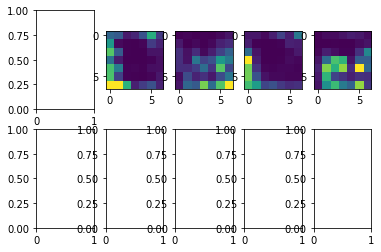

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [58]:
fig, axs = plt.subplots(2, 5)
masks = masks.cpu()
for i in range(4):
    plt.figure()
    axs[0][i+1].imshow(masks[0][i])

In [36]:
anno.shape

torch.Size([2, 1, 224, 224])

In [118]:
from random import randint

In [122]:
n = randint(0,1000)
img,anno = dataset[n]
#img,anno = transform1(img,anno)
plt.figure()
# plt.imshow(img[1].permute(1,2,0))
# plt.figure()
# plt.imshow(anno[1].permute(1,2,0))
totensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


view1,view2 = img[:1],img[1:]
mask1,mask2 = get_masks(view1,'online'),get_masks(view2,'offline')


<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_714777/323137109.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


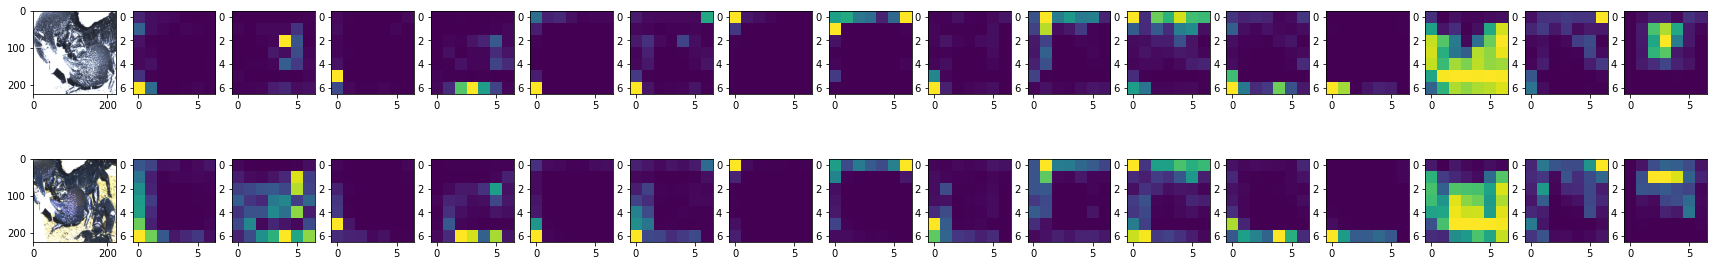

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [124]:
fig, axs = plt.subplots(2, 17,figsize=(30,5))
axs[0][0].imshow(np.exp(view1[0].permute(1,2,0)))
axs[1][0].imshow(np.exp(view2[0].permute(1,2,0)))
for i in range(16):
    plt.figure()
    axs[0][i+1].imshow(mask1[0][i])
for i in range(16):
    plt.figure()
    axs[1][i+1].imshow(mask2[0][i])
print()

TypeError: Invalid shape (2, 3, 224, 224) for image data

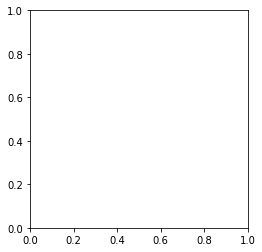

In [103]:
img,anno = dataset[7]
#img,anno = transform1(img,anno)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(anno)
totensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

In [7]:
img_normalized = normalize(totensor(img))

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [271]:
class RandomFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 256, 5)
        self.conv2 = nn.Conv2d(256, 512, 3)
        self.conv3 = nn.Conv2d(512, 1024,3,dilation=6, )
        self.conv4 = nn.Conv2d(1024, 256,3,dilation=6 )
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.interpolate(x,(49,49))
        #x = nn.AdaptiveAvgPool2d(h,w,)
        return x

In [272]:
model = RandomFeatureExtractor()

In [273]:
device='cuda:0'

In [274]:
model = model.to(device)

In [275]:
x = model(img_normalized.unsqueeze(0).to(device))

In [276]:
_,h,w = img_normalized.shape

In [277]:
features = x.detach().cpu()
_,dim,hf,wf = features.shape

In [278]:
features.shape

torch.Size([1, 256, 49, 49])

In [279]:
img_normalized.shape

torch.Size([3, 375, 500])

In [280]:
 from sklearn.cluster import KMeans

In [281]:
label_map = torch.argmax(features,dim=1)
_t = F.one_hot(label_map,dim)

In [282]:
features.reshape(dim,-1).T.shape

torch.Size([2401, 256])

In [283]:
kmeans = KMeans(n_clusters=16, random_state=0).fit(features.reshape(dim,-1).T)
_t = F.one_hot(torch.LongTensor(kmeans.labels_.reshape(hf,wf)),dim).permute(2,0,1).unsqueeze(0)

In [284]:
_t = F.interpolate(_t.float(),(h,w))
_t = torch.argmax(_t,dim=1)

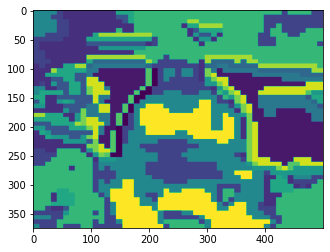

In [285]:
plt.imshow(_t[0].detach().cpu())

In [262]:
F.one_hot(torch.LongTensor(kmeans.labels_.reshape(49,49)),256).permute(2,0,1).unsqueeze(0).shape

torch.Size([1, 256, 49, 49])

In [134]:
h,w

(375, 500)